In [1]:
%matplotlib inline
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from math import trunc
import datetime
import statsmodels.api as sm
import theano
import keras

:0: FutureWarning: IPython widgets are experimental and may change in the future.
Using Theano backend.


## Loading and merging datasets
Source: [All GDELT Event Files](http://data.gdeltproject.org/events/index.html)

Datasets are zip .csv files created every day from 2013-04-01 until now. The following code creates .csv files on the local machine, but every file represents data for a whole month.

In [25]:
# Create list of headers
headers = ['GLOBALEVENTID',
           'SQLDATE',
           'MonthYear',
           'Year',
           'FractionDate',
           'Actor1Code',
           'Actor1Name',
           'Actor1CountryCode',
           'Actor1KnownGroupCode',
           'Actor1EthnicCode',
           'Actor1Religion1Code',
           'Actor1Religion2Code',
           'Actor1Type1Code',
           'Actor1Type2Code',
           'Actor1Type3Code',
           'Actor2Code',
           'Actor2Name',
           'Actor2CountryCode',
           'Actor2KnownGroupCode',
           'Actor2EthnicCode',
           'Actor2Religion1Code',
           'Actor2Religion2Code',
           'Actor2Type1Code',
           'Actor2Type2Code',
           'Actor2Type3Code',
           'IsRootEvent',
           'EventCode',
           'EventBaseCode',
           'EventRootCode',
           'QuadClass',
           'GoldsteinScale',
           'NumMentions',
           'NumSources',
           'NumArticles',
           'AvgTone',
           'Actor1Geo_Type',
           'Actor1Geo_FullName',
           'Actor1Geo_CountryCode',
           'Actor1Geo_ADM1Code',
           'Actor1Geo_Lat',
           'Actor1Geo_Long',
           'Actor1Geo_FeatureID',
           'Actor2Geo_Type',
           'Actor2Geo_FullName',
           'Actor2Geo_CountryCode',
           'Actor2Geo_ADM1Code',
           'Actor2Geo_Lat',
           'Actor2Geo_Long',
           'Actor2Geo_FeatureID',
           'ActionGeo_Type',
           'ActionGeo_FullName',
           'ActionGeo_CountryCode',
           'ActionGeo_ADM1Code',
           'ActionGeo_Lat',
           'ActionGeo_Long',
           'ActionGeo_FeatureID',
           'DATEADDED',
           'SOURCEURL']
# Create lists of all possible values of months and days
'''Years = ['2013', '2014', '2015', '2016']
Months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Days = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31']'''

Years = ['2016']
Months = ['09']
Days = ['01', '02', '03']

# Reading datasets and writing them on the local machine
for i in Years:
    for j in Months:
        path1 = r'./dataset/' + i + j + r'.csv'
        Flag = True
        for k in Days:
            path = r'http://data.gdeltproject.org/events/' + i + j + k + r'.export.CSV.zip'
            try:
                local_filename, header = urllib.request.urlretrieve(path)
            except urllib.request.HTTPError:
                break
            if Flag:
                pd.read_csv(local_filename, sep='\t', header=None, 
                        compression='zip', low_memory=False).to_csv(path1, 
                        index=False, header=headers)
                Flag = False
            else:
                pd.read_csv(local_filename, sep ='\t', header=None, 
                        compression='zip', low_memory=False).to_csv(path1, 
                        index=False, mode='a')

## Cleaning and transformation data
The following code provides:
* Exctracting information about events in certain country from files on a local machine
* Cleaning data from duplicates

In [2]:
# Loading data from the files on a local machine
Columns = ['SQLDATE', 
           'Year', 
           'FractionDate', 
           'Actor1Code',
           'Actor1Name', 
           'Actor1CountryCode', 
           'Actor2Code', 
           'Actor2Name',
           'Actor2CountryCode', 
           'IsRootEvent', 
           'EventCode', 
           'EventBaseCode',
           'EventRootCode', 
           'QuadClass', 
           'GoldsteinScale', 
           'NumMentions', 
           'NumSources', 
           'NumArticles', 
           'AvgTone',
           'Actor1Geo_Type',
           'Actor1Geo_FullName', 
           'Actor1Geo_CountryCode', 
           'Actor1Geo_Lat', 
           'Actor1Geo_Long',
           'Actor2Geo_Type', 
           'Actor2Geo_FullName', 
           'Actor2Geo_CountryCode', 
           'Actor2Geo_Lat', 
           'Actor2Geo_Long', 
           'ActionGeo_Type',
           'ActionGeo_FullName',
           'ActionGeo_CountryCode',
           'ActionGeo_Lat',
           'ActionGeo_Long',
           'DATEADDED',
           'SOURCEURL']
Years = ['2013', '2014', '2015', '2016']
Months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

Country = 'FR'
Country1 = 'FRA'
Flag = True
path1 = r'./dataset/' + Country1 + r'.csv'

for i in Years:
    for j in Months:
        path = r'./dataset/' + i + j + r'.csv'
        try:
            DataSet = pd.read_csv(path, header=0, index_col=0)
        except OSError:
            continue
        DataSet = DataSet.loc[(( ( (DataSet['Actor1Geo_CountryCode'] == Country) | (DataSet['Actor2Geo_CountryCode'] == Country) ) 
                               & ( (DataSet['Actor1CountryCode'] == Country1) | (DataSet['Actor2CountryCode'] == Country1)))
                             | ( ( (DataSet['Actor1Geo_CountryCode'] == Country) | (DataSet['Actor2Geo_CountryCode'] == Country) ) 
                               & ( (DataSet['Actor1CountryCode'] != DataSet['Actor1CountryCode']) 
                                 & (DataSet['Actor2CountryCode'] != DataSet['Actor2CountryCode'])))),
                               Columns]
        # creating new columns 'AvgToneN' and 'FractionDateN' cleaning data from duplicates
        # 'AvgToneN' is 'AvgTone', but with less possible values
        # 'FractionDateN' is truncated 'FractionDate'
        x = []
        for k in DataSet['AvgTone']:
            if k<= -20: x.append(-25)
            elif (k > -20) and (k <= -15): x.append(-17)
            elif (k > -15) and (k <= -10): x.append(-12)
            elif (k > -10) and (k <= -5): x.append(-7)
            elif (k > -5) and (k <= 0): x.append(-2)
            elif (k > 0) and (k <= 5): x.append(3)
            elif (k > 5) and (k <= 10): x.append(8)
            elif (k > 10) and (k <= 15): x.append(13)
            elif (k > 15) and (k <= 20): x.append(18)
            else: x.append(25)
        DataSet['AvgToneN'] = x
        x = []
        for k in DataSet['FractionDate']:
            x.append(trunc(k*100)/100)
        DataSet['FractionDateN'] = x
        del x
        DataSet = DataSet.drop_duplicates('SOURCEURL')
        DataSet = DataSet.drop_duplicates(['FractionDateN',
                                           'QuadClass',
                                           'GoldsteinScale',
                                           'AvgToneN',
                                           'Actor1CountryCode',
                                           'Actor2CountryCode'])
        if Flag:
            DataSet.to_csv(path1, header=True)
            Flag = False
        else:
            DataSet.to_csv(path1, header=False, mode='a')
        del DataSet

DataSet = pd.read_csv(path1, header=0, index_col=0, parse_dates=['SQLDATE', 'DATEADDED'], 
                      infer_datetime_format=True)

# aggregating data. Every day has a lot of events. If event doesn't have event with AvgTone less than -15 
# and GoldsteinScale = -10 AvgTone is calculated as average of AvgTone all events in a certain day,
# otherwise - minimum AvgTone
Y = []
X = []
E = []
U = []
Lat = []
Long = []

# filling empty 'DATEADDED' values
I = []
l = len(DataSet['SQLDATE'])
for i in range(l):
    if DataSet.loc[DataSet.index[i], 'DATEADDED'] != DataSet.loc[DataSet.index[i], 'DATEADDED']:
        if DataSet.loc[DataSet.index[i], 'SQLDATE'] >= datetime.datetime.strptime('2013-04-01', '%Y-%m-%d'):
            DataSet.loc[DataSet.index[i], 'DATEADDED'] = DataSet.loc[DataSet.index[i], 'SQLDATE']
        else:
            I.append(i)
DataSet = DataSet.drop(DataSet.index[I])

DataSet = DataSet.sort(columns='DATEADDED', ascending=True)
while (len(DataSet['DATEADDED']) > 0):
    Date = DataSet.loc[DataSet.index[0], 'DATEADDED']
    D = pd.DataFrame([(0, 0, 0, '-', 0, 0)], columns=['x', 'e', 'g', 'u', 'la', 'lo'])
    D.loc[D.index[0]] = [DataSet.loc[DataSet.index[0], 'AvgTone'],
                         DataSet.loc[DataSet.index[0], 'EventCode'],
                         DataSet.loc[DataSet.index[0], 'GoldsteinScale'],
                         DataSet.loc[DataSet.index[0], 'SOURCEURL'],
                         DataSet.loc[DataSet.index[0], 'ActionGeo_Lat'],
                         DataSet.loc[DataSet.index[0], 'ActionGeo_Long']]
    I = [0]
    i = 1
    while (DataSet.loc[DataSet.index[i], 'DATEADDED'] == Date):
        I.append(i)
        D.loc[D.last_valid_index()+1] = [DataSet.loc[DataSet.index[i], 'AvgTone'],
                                         DataSet.loc[DataSet.index[i], 'EventCode'],
                                         DataSet.loc[DataSet.index[i], 'GoldsteinScale'],
                                         DataSet.loc[DataSet.index[i], 'SOURCEURL'],
                                         DataSet.loc[DataSet.index[i], 'ActionGeo_Lat'],
                                         DataSet.loc[DataSet.index[i], 'ActionGeo_Long']]
        i = i +1
        if i > (len(DataSet['DATEADDED'])-1):
            break
    Y.append(Date)
    D = D.sort(columns=['g','x'], ascending=[1,1])
    if (D.loc[D.index[0], 'g'] == -10) and (D.loc[D.index[0], 'x'] < -15):
        X.append(D.loc[D.index[0], 'x'])
        E.append(D.loc[D.index[0], 'e'])
        U.append(D.loc[D.index[0], 'u'])
        Lat.append(D.loc[D.index[0], 'la'])
        Long.append(D.loc[D.index[0], 'lo'])
    else:
        X.append(D['x'].mean())
        E.append(0)
        U.append('-')
        Lat.append(0)
        Long.append(0)
    DataSet = DataSet.drop(DataSet.index[I])

path1 = r'./dataset/' + 'FRATimeSeries' + r'.csv'
TS = pd.DataFrame({'Date': Y, 'Tone': X, 'EventCode': E, 'URL': U, 'Lat': Lat, 'Long': Long})        
TS.to_csv(path1, header = True)

C:\Users\Sergei\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (9,10,11,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
C:\Users\Sergei\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
C:\Users\Sergei\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (8,9,10,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
C:\Users\Sergei\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (8,9,10,11,14,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
C:\Users\Sergei\Anaconda3\lib\site-packages\pandas\io\parsers.py:1170: DtypeWarning: Columns (8,9,10,11,12,13,14,19,24,26,27,28) have 

## Exploring Data Analysis

In [2]:
path1 = r'./dataset/' + 'FRA' + r'.csv'
DataSet = pd.read_csv(path1, header=0, index_col=0, 
                      parse_dates=['SQLDATE', 'DATEADDED'], infer_datetime_format=True)

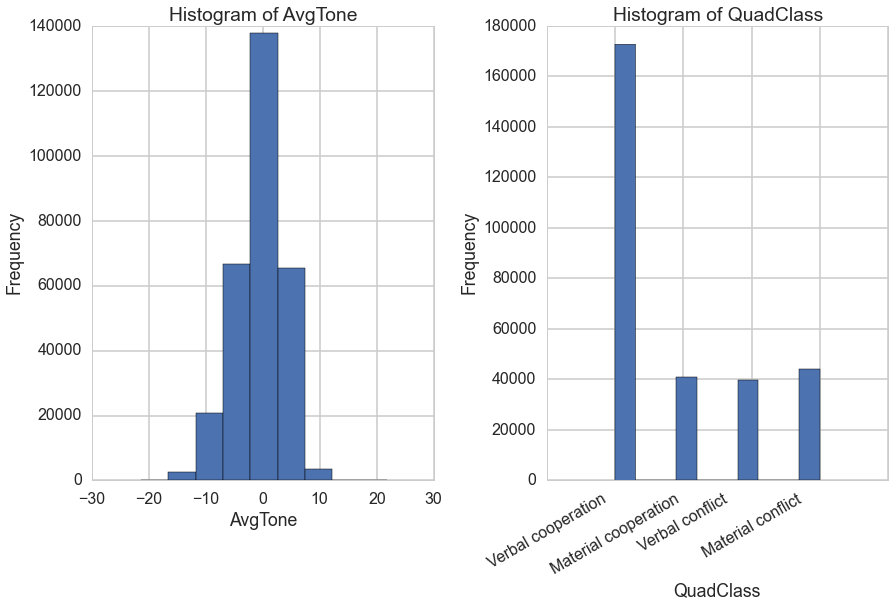

In [35]:
# building histogram of AvgTone and QuadClass
f, ax = plt.subplots(ncols = 2)
ax[0].hist(np.array(DataSet['AvgTone']))
ax[0].set_title('Histogram of AvgTone')
ax[0].set_xlabel('AvgTone')
ax[0].set_ylabel('Frequency')

ax[1].hist(np.array(DataSet['QuadClass']))
ax[1].set_title('Histogram of QuadClass')
ax[1].set_xlabel('QuadClass')
ax[1].set_ylabel('Frequency')
ax[1].set_xticklabels(['Verbal cooperation', 'Material cooperation', 'Verbal conflict', 'Material conflict'],
                     rotation=30)
ax[1].set_xlim([0, 5])
f.tight_layout()

The vast majority of events has a neutral tone and 'verbal cooperation' type.

In [2]:
path1 = r'./dataset/' + 'FRATimeSeries' + r'.csv'
TS = pd.read_csv(path1, header=0, index_col=0, parse_dates=['Date'],
                 infer_datetime_format = True)

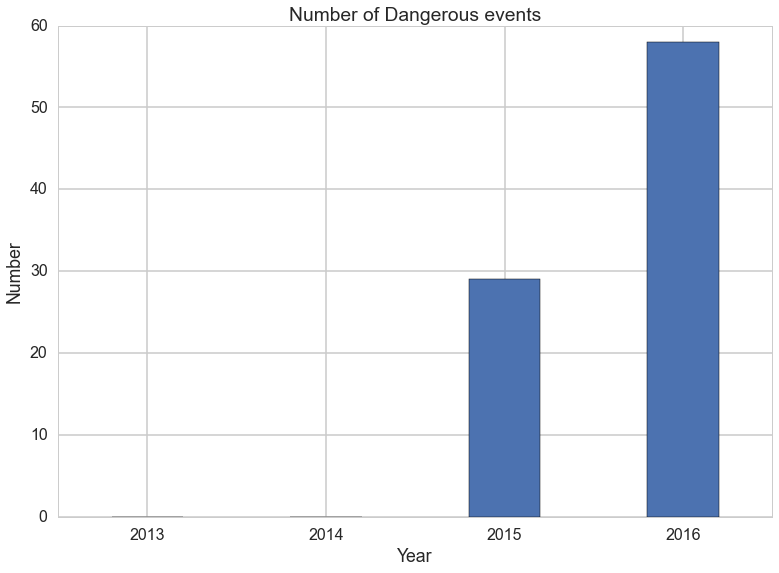

In [3]:
#building how many dangerous events were in certain year
Years = [2013, 2014, 2015, 2016]
N = [0, 0, 0, 0]
l = len(TS['Date'])
for i in range(l):
    d = TS.loc[TS.index[i], 'Date'].year
    if (d == 2013) and (TS.loc[TS.index[i], 'Tone'] < -15):
        N[0] = N[0] +1
    if (d == 2014) and (TS.loc[TS.index[i], 'Tone'] < -15):
        N[1] = N[1] +1
    if (d == 2015) and (TS.loc[TS.index[i], 'Tone'] < -15):
        N[2] = N[2] +1
    if (d == 2016) and (TS.loc[TS.index[i], 'Tone'] < -15):
        N[3] = N[3] +1

f, ax = plt.subplots()
ax.bar(Years, N, width=0.4, align='center')
ax.set_title('Number of Dangerous events')
ax.set_xlabel('Year')
ax.set_ylabel('Number')
ax.set_xticks([2013, 2014, 2015, 2016])
ax.set_xticklabels(['2013', '2014', '2015', '2016'])

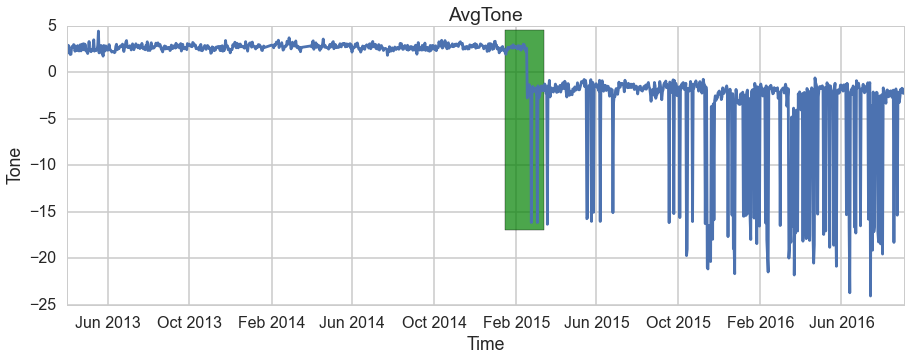

In [20]:
#building of changing of AvgTone
f, ax = plt.subplots(figsize=(15,5))
ax.plot(TS['Date'], TS['Tone'])
ax.set_title('AvgTone')
ax.set_xlabel('Time')
ax.set_ylabel('Tone')
ax.fill_between([datetime.datetime.strptime('2015-01-15', '%Y-%m-%d'), datetime.datetime.strptime('2015-03-15', '%Y-%m-%d')],
                -17, 4.5, facecolor='green', alpha = .7, interpolate=True)

There was a significant change in behavour of AvgTone ('green' area in the picture above), but it's difficult to find reasons for that.

Let's have a close look at events in 2016.

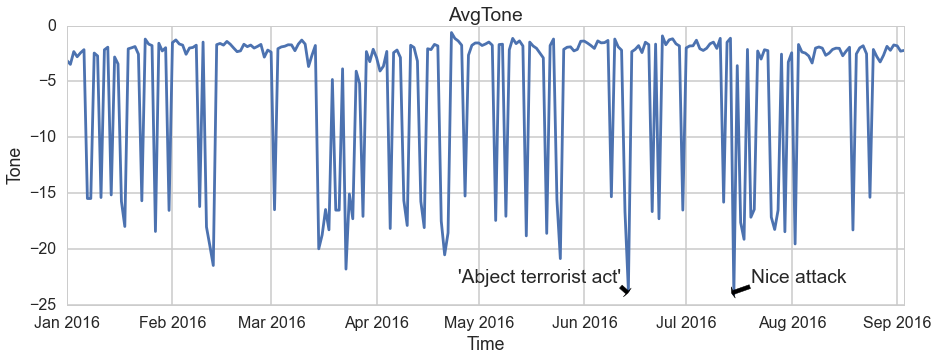

In [191]:
f, ax = plt.subplots(figsize=(15,5))
ax.plot(TS.loc[TS['Date'] >= datetime.datetime.strptime('2016-01-01', '%Y-%m-%d'), 'Date'],
        TS.loc[TS['Date'] >= datetime.datetime.strptime('2016-01-01', '%Y-%m-%d'), 'Tone'])
ax.set_title('AvgTone')
ax.set_xlabel('Time')
ax.set_ylabel('Tone')
ax.annotate('Nice attack', xy=[datetime.datetime.strptime('2016-07-14', '%Y-%m-%d'), -24],
            xytext=[datetime.datetime.strptime('2016-07-20', '%Y-%m-%d'), -23],
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate("'Abject terrorist act'", xy=[datetime.datetime.strptime('2016-06-14', '%Y-%m-%d'), -24],
            xytext=[datetime.datetime.strptime('2016-04-25', '%Y-%m-%d'), -23],
            arrowprops=dict(facecolor='black', shrink=0.05))

## Forecasting Data

In [4]:
path1 = r'./dataset/' + 'FRATimeSeries' + r'.csv'
TS = pd.read_csv(path1, header = 0, index_col = 0, parse_dates = ['Date'], infer_datetime_format = True)

# dividing data into training and test sets
l = round(TS.last_valid_index() * 0.95)
train = pd.Series(np.array(TS.loc[TS.index[0:l], 'Tone']), index=TS.loc[TS.index[0:l], 'Date'])
test = pd.Series(np.array(TS.loc[TS.index[l:], 'Tone']), index=TS.loc[TS.index[l:], 'Date'])

Let's check stationarity of the data for assessment of possibility to apply ARMA/ ARIMA model.

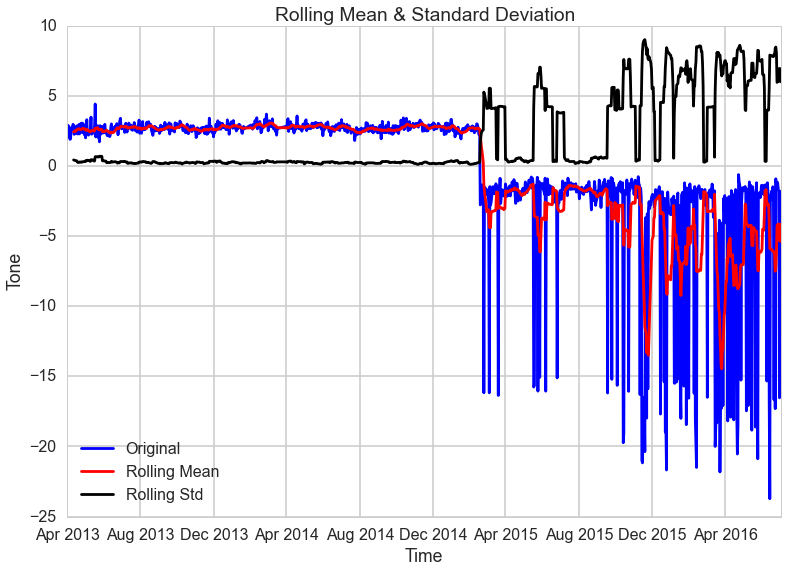

In [29]:
#testing stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #statistics
    orig = plt.plot(timeseries.index, timeseries, color='blue',label='Original')
    mean = plt.plot(timeseries.index, rolmean, color='red', label='Rolling Mean')
    std = plt.plot(timeseries.index, rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Time')
    plt.ylabel('Tone')
    
test_stationarity(train)

Standard deviation and mean are both changing with time so it's not the stationary time series.

Let's apply transformation and check stationarity again.

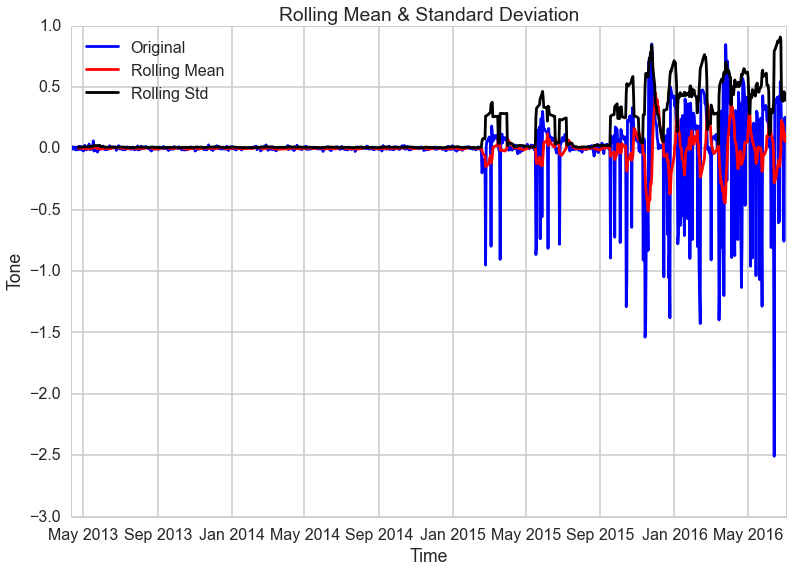

In [30]:
# taking log transformation, but before plusing 25
train_log = np.log(train+25)
moving_avg = pd.rolling_mean(train_log,12)
train_log_moving_avg_diff = train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(train_log_moving_avg_diff)

It's better, but there are still changes in mean and st. deviation, so it's quite difficult to chose a transformation. 

In this case it may be better to implement neural network.

In [23]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
np.random.seed(7)

In [37]:
lag = 30
k = 30 # number of days for forecasting
dataset1 = np.array(TS['Tone'])
min = dataset1.min()
max = dataset1.max()

# normalizing data
dataset1 = MinMaxScaler(feature_range=(0, 1)).fit_transform(dataset1)

# dividing data into training and test sets
l = round(TS.last_valid_index() * 0.95)
train1 = dataset1[0:l]
train1 = np.reshape(train1, (len(train1), 1))
l1 = len(dataset1[l:])
test1 = dataset1[l:]
test1 = np.reshape(test1, (len(test1), 1))

# convert an array of values into a dataset matrix
def create_dataset(dataset, lag=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-lag):
        a = dataset[i:(i+lag), 0]
        dataX.append(a)
        dataY.append(dataset[i + lag, 0])
    return np.array(dataX), np.array(dataY)


Xtrain1, Ytrain1 = create_dataset(train1, lag)
Xtest1, Ytest1 = create_dataset(test1, lag)

Xtrain1 = np.reshape(Xtrain1, (Xtrain1.shape[0], 1, Xtrain1.shape[1]))
Xtest1 = np.reshape(Xtest1, (Xtest1.shape[0], 1, Xtest1.shape[1]))

model = Sequential()
model.add(LSTM(4, input_dim=lag))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(Xtrain1, Ytrain1, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0475
Epoch 2/100
2s - loss: 0.0187
Epoch 3/100
2s - loss: 0.0181
Epoch 4/100
2s - loss: 0.0173
Epoch 5/100
2s - loss: 0.0171
Epoch 6/100
2s - loss: 0.0166
Epoch 7/100
2s - loss: 0.0164
Epoch 8/100
2s - loss: 0.0162
Epoch 9/100
2s - loss: 0.0160
Epoch 10/100
2s - loss: 0.0156
Epoch 11/100
2s - loss: 0.0157
Epoch 12/100
2s - loss: 0.0158
Epoch 13/100
2s - loss: 0.0154
Epoch 14/100
2s - loss: 0.0156
Epoch 15/100
2s - loss: 0.0152
Epoch 16/100
2s - loss: 0.0151
Epoch 17/100
2s - loss: 0.0151
Epoch 18/100
2s - loss: 0.0148
Epoch 19/100
2s - loss: 0.0148
Epoch 20/100
2s - loss: 0.0147
Epoch 21/100
2s - loss: 0.0145
Epoch 22/100
2s - loss: 0.0146
Epoch 23/100
2s - loss: 0.0144
Epoch 24/100
2s - loss: 0.0142
Epoch 25/100
2s - loss: 0.0142
Epoch 26/100
2s - loss: 0.0142
Epoch 27/100
2s - loss: 0.0143
Epoch 28/100
2s - loss: 0.0138
Epoch 29/100
2s - loss: 0.0138
Epoch 30/100
2s - loss: 0.0140
Epoch 31/100
2s - loss: 0.0137
Epoch 32/100
2s - loss: 0.0135
Epoch 33/100
2s -

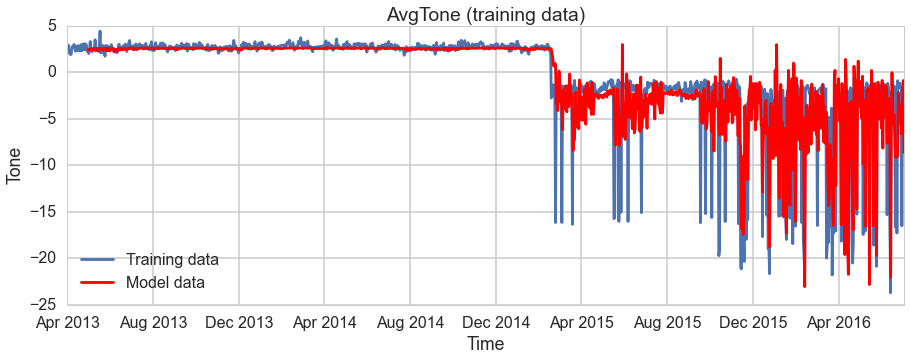

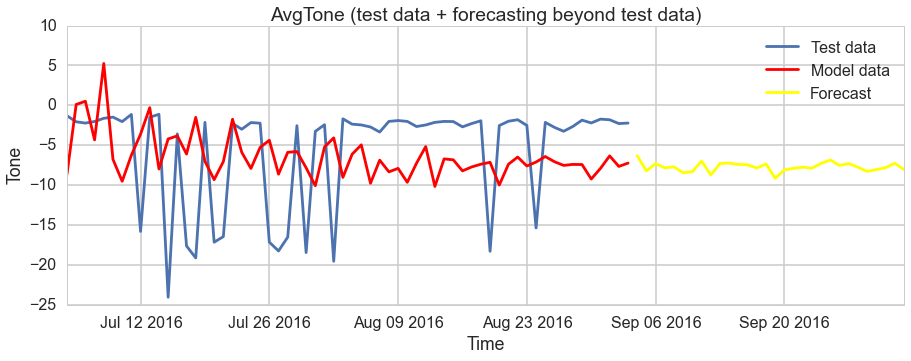

In [38]:
res = model.predict(Xtrain1)
res1 = res * (max-min) + min

# showing training data
f, ax = plt.subplots(figsize=(15,5))
ax.plot(TS.loc[TS.index[0:l], 'Date'], TS.loc[TS.index[0:l], 'Tone'], label='Training data')
ax.plot(TS.loc[TS.index[lag:l], 'Date'], res1, color='red', label='Model data')
ax.set_title('AvgTone (training data)')
ax.set_xlabel('Time')
ax.set_ylabel('Tone')
ax.legend(loc='best')

# showing test data + forecasting beyond test data
Y=[]
Y.append(res[-1] *(max - min) + min)
dataset1 = dataset1[0:l]

for i in range(l1 + k - 1):   
    dataset1 = np.delete(dataset1, 0)
    dataset1 = np.append(dataset1, res[-1])
    train1 = dataset1
    train1 = np.reshape(train1, (len(train1), 1))
    Xtrain1, Ytrain1 = create_dataset(train1, lag)
    Xtrain1 = np.reshape(Xtrain1, (Xtrain1.shape[0], 1, Xtrain1.shape[1]))
    res = model.predict(Xtrain1)
    Y.append(res[-1] *(max - min) + min)

Dates = []
for i in range(k):
    Dates.append(TS.loc[TS.last_valid_index(), 'Date'] + datetime.timedelta(days = i+1))

f, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(TS.loc[TS.index[l:], 'Date'], TS.loc[TS.index[l:], 'Tone'], label='Test data')
ax1.plot(TS.loc[TS.index[l:], 'Date'], Y[0:l1], color='red', label='Model data')
ax1.plot(Dates, Y[l1:], color='yellow', label='Forecast')
ax1.set_title('AvgTone (test data + forecasting beyond test data)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Tone')
ax1.legend(loc='best')

We can see significant differences between test and model data in the last picture. Moreover, forecast line (yellow color) collapses, so decision needs some improvements.

Future steps:
* find appropriate transformation for input data
* play with parameters of NN
* use genetic algorithm instead of NN
* build a model for forecasting based on not only time, but also some other independent variables.
